# Geospatial data processing

Today we're going to look at pulling climate statistics out for suburbs from a shapefile. First let's look at the libraries we're going to use

In [1]:
import geopandas
import shapely
import pandas
import numpy 
import rasterio
import affine

We're using `geopandas` to manage the vector data, and `rasterio` to manage the raster data. You can find the documentation for these libraries here:

- [`geopandas` documentation](http://geopandas.org) - uses `shapely` and `pandas` under the hood to manage geometries and tabular attributes respectively.
- [`rasterio` documentation](https://rasterio.readthedocs.io/en/latest/) - uses `numpy` and `affine` under the hood to manage arrays and transformations respectively.

Feel free to have a browse around and see what else these libraries can do for you. There's also a specialized StackExchange (like a subreddit for StackOverflow) on geospatial stuff here: https://gis.stackexchange.com which typically has a higher signal-to-noise ratio if you get stuck.

### Downloading and parsing BoM climate data

I've downloaded the BoM data for Australia from here: http://www.bom.gov.au/jsp/ncc/climate_averages/temperature/index.jsp?maptype=3&period=aut#maps

BoM, in it's own wisdom, uses a Grid text file which has no useful geospatial aspects so we need a seperate function to put it into a useful format. Feel free to dumpster dive if you want to see how to generate your own geotiffs from numpy arrays otherwise just ignore this function and treat it as a black-box conversion service.

In [2]:
def grid_to_geotiff(filename, return_data=False):
    """ Load data from a Bureau of Meterology 'grid' file and dump out to geotiff
        Output is written to geotiff
        Parameters:
            filename - the file name of the BoM grid file to convert
            return_data - if true, then a Numpy array with the imported
                data is returned when conversion is successful.
    """
    # First six lines are metadata
    # Note: gonna assume the origin is WGS84
    with open(filename) as fhandle:
        meta = {}
        for line in fhandle:
            key, value = line.split()
            key = key.lower()
            meta[key] = value
            if len(meta) == 6:
                break

    # Handle sloppy labelling from BoM
    for idx in ('x', 'y'):
        if meta.get(idx + 'llcorner') is not None:
            meta[idx + 'llcenter'] = meta[idx + 'llcorner']

    # Convert metadata to right format
    type_mapping = {'ncols': int, 'nrows': int,
                    'xllcenter': float, 'yllcenter': float,
                    'cellsize': float, 'nodata_value': float}
    for key, typef in type_mapping.items():
        meta[key] = typef(meta[key])

    # Next lines are info - swap out nodata with nans
    # Last lines are also metadata 'header' but we don't care about that
    data = numpy.genfromtxt(filename, dtype=numpy.float64,
                            skip_header=6, skip_footer=18)

    # Check whether we have masked values to deal with
    has_mask = (meta.get('nodata_value') is not None)
    if has_mask:
        has_mask = True
        nodata_mask = (data - meta['nodata_value']) ** 2 < 1e-6

    ## MAKE GEOTIFF
    # Generate the transform for the grid
    aff = affine.Affine.translation(
        meta['xllcenter'] - meta['cellsize'] * 0.5,
        meta['yllcenter'] + (meta['nrows'] - 0.5) * meta['cellsize']
    ) * affine.Affine.scale(meta['cellsize'], -meta['cellsize'])

    # Make metadata for geotiff
    geotiff_meta = {
        'transform': aff,
        'width': meta['ncols'],
        'height': meta['nrows'],
        'nodata': meta['nodata_value'],
        'tiled': 'no',
        'crs': {'init': 'epsg:4326'},  # assuming WGS84
        'driver': 'GTiff',
        'dtype': 'float64',
        'blockxsize': 128,
        'blockysize': 128,
        'count': 1
    }

    # Write out to file
    with rasterio.open(filename + '.geotiff', 'w', **geotiff_meta) as sink:
        sink.write_band(1, data)
        if has_mask:
            sink.write_mask(nodata_mask.astype(bool))

    # If we're returning the data, convert data mask to numpy.nan
    if return_data:
        if has_mask:
            data[nodata_mask] = numpy.nan
        return data
    else:
        return filename + '.geotiff'

Now lets use this importer to read the grid file and convert it to a georeferenced GeoTIFF

In [3]:
data = {
    'spring': grid_to_geotiff('../data/minspr.txt', return_data=True),
    'summer': grid_to_geotiff('../data/minsum.txt', return_data=True),
    'autumn': grid_to_geotiff('../data/minaut.txt', return_data=True),
    'winter': grid_to_geotiff('../data/minwin.txt', return_data=True)
}

We can show a quick-and-dirty plot of Australia's minimum temperatures for each season

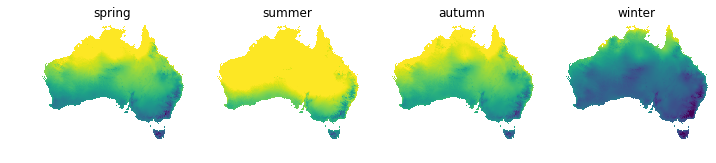

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set the min and maximum so everything uses the same scale
min_temp = -1
max_temp = 20

# Generate the plots for each season
fig, axes = plt.subplots(1, 4)
for (title, temps), ax in zip(data.items(), axes):
    ax.imshow(temps, vmin=min_temp, vmax=max_temp)
    ax.set_title(title)
    ax.set_axis_off()
fig.set_size_inches(12, 4)

### Getting a suburbs shapefile for Perth

We're going to use the suburbs shapefile to extract portions of these temperature maps for Perth. You can see the info page on `data.gov.au` here: https://data.gov.au/dataset/wa-suburb-locality-boundaries-psma-administrative-boundaries

I've not included the actual data in the git repo as it's quite big (about 50 Mb) - head to https://data.gov.au/dataset/wa-suburb-locality-boundaries-psma-administrative-boundaries/resource/141fc7bd-c75f-49b5-a116-35250eea68cd and click 'download' and then put it into the `../data` folder for this week.

Once you've got the shapefile you can use `geopandas` to read it just like you'd use `pandas` to read a normal CSV.

In [5]:
suburbs = geopandas.read_file('../data/WA_LOCALITY_POLYGON_shp/WA_LOCALITY_POLYGON_shp.shp')

Let's take a look at what we've got

In [6]:
suburbs.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,WA_LOCALIT,WA_LOCAL_1,WA_LOCAL_2,WA_LOCAL_3,WA_LOCAL_4,WA_LOCAL_5,WA_LOCAL_6,WA_LOCAL_7,geometry
0,17275,2018-09-10,None,WA3309,2017-11-01,None,ALFRED COVE,None,None,G,None,5,"POLYGON ((115.81611872955 -32.03673795159, 115..."
1,15444,2015-09-14,None,WA3315,2015-11-09,None,PEPPERMINT GROVE,None,None,G,None,5,"POLYGON ((115.77316140578 -32.00143597369, 115..."
2,15515,2015-09-14,None,WA3348,2015-11-09,None,HOCKING,None,None,G,None,5,"POLYGON ((115.80882615245 -31.76281081704, 115..."
3,12813,2014-05-21,None,WA3351,2013-08-06,None,CONNOLLY,None,None,G,None,5,"POLYGON ((115.74206469857 -31.7425653915575, 1..."
4,10548,2013-02-21,None,WA3355,2013-04-30,None,BORDEN,None,None,G,None,5,"POLYGON ((118.256046998337 -34.0708927822146, ..."


What we can see is that there is a bunch of rows, each with potentially useful information. The key difference is the `geometry` column - this is a set of shapes which contains a 'geometry' for the suburb - in this case a polygon representing the suburb outline.

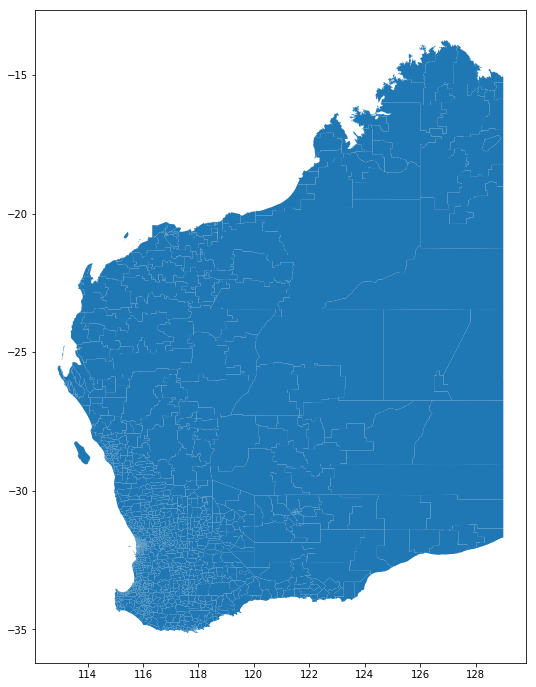

In [22]:
# Quick and dirty map of our suburbs
suburbs.plot(figsize=(12, 12))

Let's look at an individual suburb

In [7]:
suburb = suburbs.iloc[0]  # let's play with the first record in the file
suburb

LC_PLY_PID                                                17275
DT_CREATE                                            2018-09-10
DT_RETIRE                                                  None
LOC_PID                                                  WA3309
WA_LOCALIT                                           2017-11-01
WA_LOCAL_1                                                 None
WA_LOCAL_2                                          ALFRED COVE
WA_LOCAL_3                                                 None
WA_LOCAL_4                                                 None
WA_LOCAL_5                                                    G
WA_LOCAL_6                                                 None
WA_LOCAL_7                                                    5
geometry      POLYGON ((115.81611872955 -32.03673795159, 115...
Name: 0, dtype: object

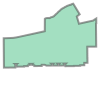

In [8]:
suburb.geometry

This geometry is a regular shapely shape and we can access a whole bunch of analytics from here. For example we can get the boundary:

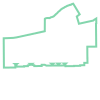

In [9]:
suburb.geometry.boundary

We could buffer on this boundary to find locations within a certain distance of the suburb edge

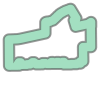

In [10]:
near_boundary = suburb.geometry.boundary.buffer(0.001)
near_boundary

If we only care about properties inside the suburb we can generate the intersection of the buffer with the suburb

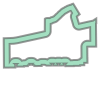

In [11]:
suburb.geometry.intersection(near_boundary)

We can also get the suburb centroid etc etc

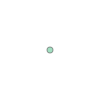

In [12]:
suburb.geometry.centroid

Have a play with the attributes here and also take a look at the [`shapely` documentation for more spatial analysis methods](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods)

### Getting temperature data for the suburb

Next we're going to look at using Rasterio to pull out the temperature pixels for each suburb. 

Before we generate the masks we need to make sure that the polygons and the rasters have the same projection. Fortunately `geopandas` makes this easy for us:

In [14]:
# Check the initial suburb coordinate reference system
suburbs.crs

{'init': 'epsg:4283'}

In [15]:
# Convert to EPSG 4326 (Web Mercator, aka EPSG:900913)
suburbs.to_crs({'init': 'epsg:4326'}, inplace=True)

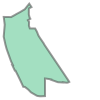

In [16]:
# Pull out our suburb again
suburb = suburbs.iloc[5]
suburb.geometry  # this will look the same but the numbers are diff

The key piece of functionality we want is in `rasterio.rasterize` (funnily enough my search for copy-paste code [led me to a GitHub issue I contributed to in 2014](https://github.com/mapbox/rasterio/issues/154) - it's nice when past you makes your job easier). Basically we create a mask for the image by burning the polygons into the raster

In [17]:
from rasterio.features import rasterize

# Generate mask using first image for metadata
mask_value = 1
fill_value = 0
with rasterio.open('../data/minaut.txt.geotiff') as src:
    mask = rasterize(
        [(suburb.geometry.__geo_interface__, mask_value)], 
        out_shape=src.shape, 
        transform=src.transform, 
        all_touched=True, 
        fill=fill_value).astype(bool)

Note that there might not be many pixels touched by the polygon at this scale, but they're the right ones that we want!

In [18]:
numpy.count_nonzero(mask) # see how many pixels we've picked up

2

Now we can use the mask to select the relevant pixels out of the geotiff to get temperature data for the suburb for each season

In [19]:
datasets = [
    ('autumn', '../data/minaut.txt.geotiff'),
    ('spring', '../data/minspr.txt.geotiff'),
    ('summer', '../data/minsum.txt.geotiff'),
    ('winter', '../data/minwin.txt.geotiff')
]

results = {}
for key, filename in datasets:
    with rasterio.open(filename) as src:
        results[key] = src.read(1)[mask]
    
results

{'autumn': array([14.63667, 14.83   ]),
 'spring': array([10.25   , 10.47667]),
 'summer': array([17.52   , 17.71333]),
 'winter': array([8.806666, 9.03    ])}

**Exercise:** Write a function to do this data extraction for all the suburbs in the shapefile, with some kind of summary statistic (e.g. mean) to turn the array of returned pixels into a single value. 

How might you use this data to predict faults in the ATCO fault dataset?